* The original of this file can be found here: https://github.com/tomsercu/gan-tutorial-pytorch
* This notebook has been adjusted for our particular needs to have a clear structure on how to train a basic GAN

# Preliminaries


We have the ambitious goal for this tutorial to be an introduction to both
* Generative Adversarial Networks (GANs) and
* deep learning with pytorch

Since GANs are a more advanced topic in deep learning, we will introduce the deep learning concepts at an intuitive level in function of GANs, and focus on how they're implemented in pytorch.
We will translate GAN / deep learning concepts in code as soon as possible.
In the code we try to strip away complexity and abstractions, to make it easier to absorb the concepts.
The resulting code is minimalistic and very explicit, designed for learning, *not* for running real experiments.

Here is what you will learn:
* GANs are generative models that learn to generate data, based on a min-max/adversarial game between a Generator (G) and Discriminator (D).
* The parameters of both Generator and Discriminator are optimized with Stochastic Gradient Descent (SGD), for which the gradients of a loss function with respect to the neural network parameters are easily computed with pytorch's autograd. This is at the core of deep learning.
* How these concepts translate into pytorch code for GAN optimization.

Overview of the tutorial:
1. GAN intro
2. Defining the neural networks in pytorch, computing a forward pass
3. Optimization with SGD - linear regression example
4. Training our GAN

# 1. GAN first introduction

GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

Let's start with defining the generator G and discriminator D in pytorch.

# 2. Define the neural networks in pytorch
We'll introduce some libraries we will be using, as well as a function that allows us to display images for testing purposes.

In [6]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, _, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure(figsize=(16,12))
    plt.title(f"Label: {_}")
    plt.imshow(grid.numpy())

3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]
2.5.1+cpu


## Defining the neural networks

Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator `D`:

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=108654): #(bs x 108654) -> (bs x 1 x 199 x 546)
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 108654) # flatten (bs x 1 x 199 x 546) -> (bs x 108654)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

And a small 2-layer neural network for the generator `G`. `G` takes a 10000-dimensional noise vector (subject to any changes for your system) and generates an output of the size matching the 199 x 546 dimension images we are working with.

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim=10000):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 108654)
        
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 199, 546)
        return out
    

And a little test to ensure that the discriminator and generator is set up correctly.

In [10]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=108654, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=10000, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=108654, bias=True)
)


Note that the dimensions of D input and G output were defined for MNIST data.

## Testing the neural networks (forward pass)
We can do a forward pass of two samples like so.

In [19]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 10000)
# This is how to do a forward pass (calls the .forward() function under the hood)
x_gen = G(z)
x_gen.shape

torch.Size([2, 1, 199, 546])

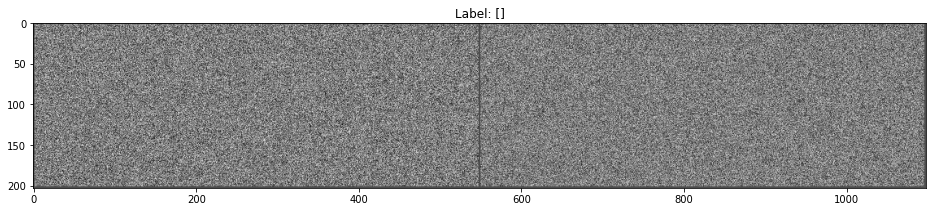

In [20]:
z = torch.randn(2, 10000)
show_imgs(G(z), [])

## Loading the data and computing forward pass
This is code from Dominika's preprocessing.ipynb that is slightly adjusted to work for the purpose of GANs. Her notebook will have much of the details explained about the code below.

In [11]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# hyperparameters - to be adjusted
TEST_TRAIN_SPLIT = 0.3
BATCH_SIZE = 32
OUTPUT_PATH = "../../utils/augmented_data"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(OUTPUT_PATH, transform=transform)

n_test = int(np.floor(TEST_TRAIN_SPLIT * len(dataset)))
n_train = len(dataset) - n_test

train_ds, test_ds = random_split(dataset, [n_train, n_test])

train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 4)


# some useful info about the dataset
print(f"Classes: {dataset.classes}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of testing samples: {len(test_ds)}")

for i, (x, _) in enumerate(train_dl):
    print(f"Image shape: {x.shape}")
    break

Classes: ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']
Number of training samples: 1440
Number of testing samples: 616
Image shape: torch.Size([32, 1, 199, 546])


In [22]:
x, _ = dataset[1200] # Take a random sample from our dataset

# We can access the image data (x) and the label (_) like so:
print(x)

print(_) # class label in numerical format
print(dataset.classes[_]) # class label in string format


tensor([[[0.0157, 0.0078, 0.0353,  ..., 0.0392, 0.0431, 0.0510],
         [0.0784, 0.0471, 0.0000,  ..., 0.0588, 0.0510, 0.0549],
         [0.0706, 0.0549, 0.0275,  ..., 0.0510, 0.0118, 0.0039],
         ...,
         [0.0941, 0.0314, 0.0275,  ..., 0.0353, 0.0157, 0.0667],
         [0.0784, 0.0196, 0.0549,  ..., 0.0314, 0.0118, 0.0392],
         [0.0314, 0.0000, 0.0392,  ..., 0.0118, 0.0392, 0.0627]]])
0
AMD


Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at a sample:

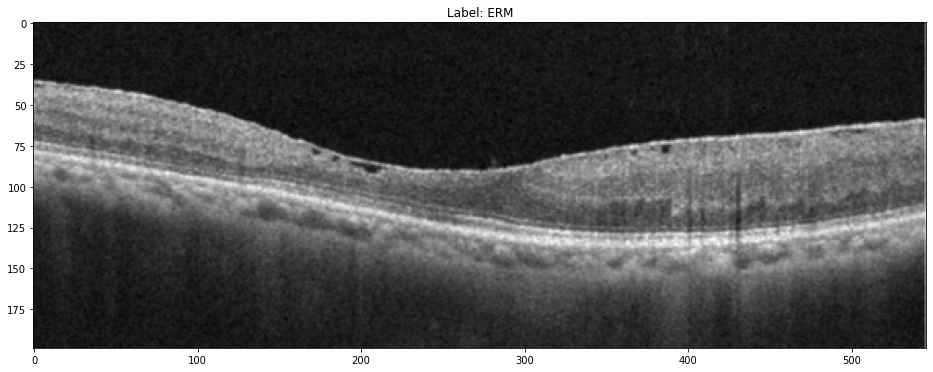

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

ix=1462
x, _ = dataset[ix]

show_imgs(x.squeeze(), dataset.classes[_])

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [24]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.4605]], grad_fn=<SigmoidBackward0>)

Now that we are able to unpack single images, lets have a look at how we can iterate over batched samples that we will be feeding into our models.

In [25]:
# How you can get a batch of images from the dataloader:

test = iter(train_dl) # Creates an iterable list of sample batches we can call upon
xbatch, _ = next(test) # gets the next batch of 32 x 1 x 199 x 546: minibatch of 32 samples
print(xbatch)
xbatch.shape
D(xbatch) # 32x1 tensor: 32 predictions of probability of input being real.
D(xbatch).shape

tensor([[[[0.0784, 0.0706, 0.0745,  ..., 0.0706, 0.0784, 0.0745],
          [0.0510, 0.0627, 0.0745,  ..., 0.0824, 0.0706, 0.0627],
          [0.0706, 0.0824, 0.0784,  ..., 0.0824, 0.0745, 0.0706],
          ...,
          [0.0902, 0.0863, 0.0863,  ..., 0.1059, 0.1216, 0.1216],
          [0.0667, 0.0824, 0.0784,  ..., 0.1216, 0.0980, 0.0902],
          [0.0824, 0.0941, 0.0745,  ..., 0.1137, 0.0941, 0.0902]]],


        [[[0.1059, 0.1098, 0.0980,  ..., 0.4431, 0.4941, 0.5216],
          [0.1020, 0.0784, 0.1098,  ..., 0.4824, 0.4706, 0.4863],
          [0.1137, 0.1020, 0.1255,  ..., 0.4667, 0.4941, 0.4980],
          ...,
          [0.0980, 0.1216, 0.1020,  ..., 0.1098, 0.1098, 0.1137],
          [0.1216, 0.0824, 0.1137,  ..., 0.0980, 0.1020, 0.0980],
          [0.1137, 0.1098, 0.1137,  ..., 0.1255, 0.1176, 0.1020]]],


        [[[0.1686, 0.1843, 0.1608,  ..., 0.1529, 0.1608, 0.1333],
          [0.1686, 0.1294, 0.1373,  ..., 0.1647, 0.1569, 0.1412],
          [0.1843, 0.1569, 0.1451,  ..

torch.Size([32, 1])

We can also use the show_imgs() function to show batches of images to see what they are like, as well as show the labels for all of the images.

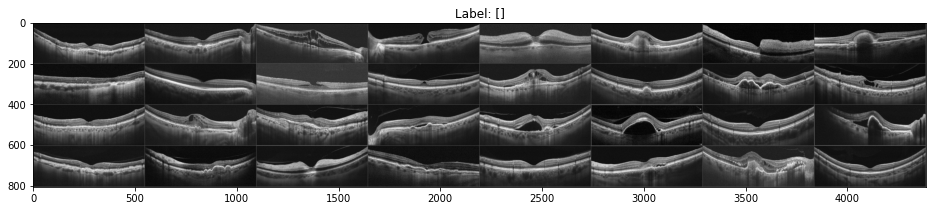

In [26]:
labels = []
# for i in _:
#     labels.append(dataset.classes[i])

show_imgs(xbatch, labels)

# 4. Making our GANs explainable.
This code is inspired by the code from the repo: https://github.com/explainable-gan/XAIGAN/tree/master

In [57]:
val = 0

def temp_store(value):
    global val
    val = value

def temp_get():
    global val
    return val

In [98]:
from captum.attr import Saliency
from vector_utils import values_target, images_to_vectors, normalize_vector

def get_explanation(generated_data, discriminator, predicted_data, cuda=False, trained_data=None):
    
    # initialize temp values to all 1s
    temp = values_target(size=generated_data.size(), value=1.0, cuda=cuda)

    # mask values with low prediction
    mask = (predicted_data < 0.5).view(-1)
    indices = (mask.nonzero(as_tuple=False)).detach().cpu().numpy().flatten().tolist()

    data = generated_data[mask, :]

    if len(indices) > 1:
        # XAI using saliency (maybe investigate others)
        for i in range(len(indices)):
            explainer = Saliency(discriminator)
            temp[indices[i], :] = explainer.attribute(data[i, :])
        print(temp.size())

    # If using GPU, store the value into cuda storage
    if cuda:
        temp = temp.cuda()
    temp_store(normalize_vector(temp))

This code replaces our usual backwards call for our model, adjusts the gradient matrix with values from the explanation matrix.

NOTE: in your training loop you must replace your backwards loop of your GENERATOR (not discriminator) to apply the explanation matrix correctly.

In [92]:
def explanation_hook(module, grad_input, grad_output):
    explained_data = temp_get()

    """ Hook for explanation of the discriminator """
    temp = images_to_vectors(explained_data)
    new_grad = grad_input[0] + 0.2*(grad_input[0]*temp)

    return(new_grad,)

# 5. Back to GANs: The min-max game.

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.



### Putting it all together: the full training loop

In [ ]:
import torch

# Test scrip to ensures to see if cuda is activated on local machine
print(torch.cuda.is_available())

False


Device:  cpu


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


torch.Size([32, 1, 199, 546])
grad input:  tensor([[-3.6343e-05, -6.5084e-05,  5.0209e-06,  ..., -2.4255e-05,
         -1.5492e-05, -2.7812e-05],
        [-3.4678e-05, -6.0982e-05,  1.5359e-06,  ..., -1.8683e-05,
         -1.6741e-05, -3.4746e-05],
        [-3.9370e-05, -7.0021e-05,  3.6439e-07,  ..., -1.6732e-05,
         -2.7673e-05, -3.4312e-05],
        ...,
        [-4.5102e-05, -6.6967e-05,  3.1915e-07,  ..., -2.5099e-05,
         -2.5928e-05, -2.4418e-05],
        [-3.8618e-05, -7.0758e-05, -1.0481e-07,  ..., -2.0840e-05,
         -1.9019e-05, -3.4567e-05],
        [-3.7046e-05, -6.8976e-05, -5.2779e-07,  ..., -2.3087e-05,
         -2.0056e-05, -3.1059e-05]])
variable pass:  tensor([[3.4171e-01, 6.1194e-01, 4.7208e-02,  ..., 2.2806e-01, 1.4566e-01,
         2.6150e-01],
        [2.8446e-01, 5.0023e-01, 1.2599e-02,  ..., 1.5326e-01, 1.3733e-01,
         2.8502e-01],
        [1.2350e-01, 2.1964e-01, 1.1430e-03,  ..., 5.2486e-02, 8.6807e-02,
         1.0763e-01],
        ...,
     

KeyboardInterrupt: 

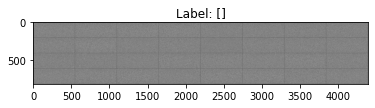

In [99]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)

# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)

# Declare our loss function for our model
criterion = nn.BCELoss()

# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)

# Creating fake samples
lab_real = torch.ones(32, 1, device=device)
lab_fake = torch.zeros(32, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(32, 10000, device=device).detach()
fig = plt.figure() # keep updating this one
plt.ion()
epochs = 1

for epoch in range(epochs): # no. of epochs

    # Replace backwards call with new function
    G.register_backward_hook(explanation_hook)

    ite = iter(train_dl)
    #print(len(dataloader))
    for i, data in enumerate(train_dl, 0): # Iterate through our dataloader to train on all our samples

        # STEP 1: Discriminator optimization step
        x_real, _ = data
        N = x_real.size(0)
        x_real = x_real.to(device)

        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        # Generate a score based on the real samples
        D_x = D(x_real)

        lossD_real = criterion(D_x, lab_real)

        # Updating D
        z = torch.randn(32, 10000, device=device).detach() # random noise, 32 samples, z_dim=10000
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration, backward step
        optimizerG.zero_grad()

        z = torch.randn(32, 10000, device=device) # random noise, 32 samples, z_dim=10000
        x_gen = G(z)
        D_G_z = D(x_gen).flatten(0)
        #lossG = criterion(D_G_z, lab_real) # -log D(G(z))

        # Generating an explanation matrix for discriminator
        get_explanation(x_gen, D, D_G_z, cuda=False)
        lossG = criterion(D_G_z, values_target(size=(N,), value=1.0, cuda=False))

        # Backwards step, applying explanation matrix to the gradient
        lossG.backward()
        optimizerG.step()

    # Logging for each epoch on loss functions for both D(x) and D(G(z))
        if True:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, [], new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(train_dl), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch

x_gen = G(fixed_noise)
collect_x_gen.append(x_gen.detach().clone())

With our training done, we can look at the results of some of our generated samples below.

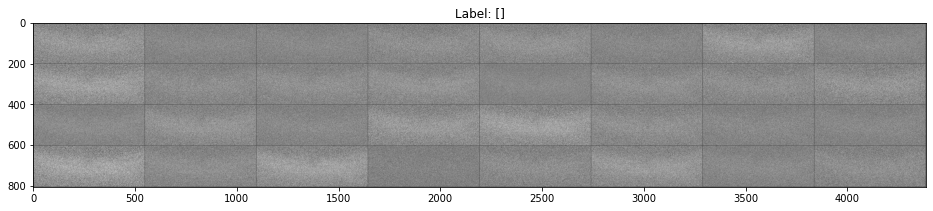

In [91]:
for x_gen in collect_x_gen:
    show_imgs(x_gen,[])